In [1]:
import csv
import pandas as pd
import numpy as np
import pprint

In [2]:
ughs_id_to_province = {}
provinces = set()
with open('../../data/navigo_all_pointcalls.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        uhgs_id = row['pointcall_uhgs_id']
        province = row['pointcall_province']
        #state = row['pointcall_state_1789_fr']
        if row['state_fr'] == 'France':
            ughs_id_to_province[uhgs_id] = province
            provinces.add(province)
        if row['homeport_state_1789_fr'] == 'France':
            ughs_id_to_province[row['homeport_uhgs_id']] = row['homeport_province']

LEVANT_PROVINCES = ['Corse', 'Languedoc',  'Roussillon', 'Provence']
#ITALIAN_FLAGS = [
#    'italien, indéterminé', 'carrarais', 'savoyard', 'vénitien', 'ragusois', 'génois', 'napolitain', 'toscan', 'romain'
#]

BIRTHPLACE_TO_PROVINCE = {
    '': 'Inconnu', 
    'Olioule': 'Provence', 
    'La Cadiere': 'Provence', 
    'Sejan [Sigean]': 'Languedoc', 
    'Roquebrune': 'Provence', 
    'Séjean': 'Provence',
    'Sejan': 'Provence', 
    'Ambon': 'Bretagne', 
    'Hieres': 'Province', 
    'Rivage [France, undetermined]': 'Inconnu', 
    'La Cadière': 'Provence', 
    'Istre': 'Provence', 
    'Cadiere': 'Provence', 
    'Aubagne': 'Provence', 
    'Seyreste': 'Provence', 
    'Solliés': 'Provence', 
    'Gruissand': 'Languedoc', 
    'Ceyreste': 'Provence', 
    'Valauris': 'Provence', 
    'Six fours': 'Provence', 
    'Gruissan': 'Provence', 
    'Mazargue': 'Provence', 
    'Roquemaure en Languedoc': 'Languedoc', 
    'Oullioulles': 'Provence', 
    'Six Fours': 'Provence', 
    'Hières': 'Provence', 
    'Mazargues': 'Provence', 
    'Sejean': 'Languedoc', 
    'Six Four': 'Provence', 
    'Roussillon': 'Roussillon', 
    'Istres': 'Provence', 
    'Gruisson': 'Languedoc', 
    'Serinan': 'Languedoc', 
    'Roquemaure': 'Languedoc', 
    'Sixfours': 'Provence'
}

FLAG_TO_GROUPING = {
    'italien, indéterminé': 'Italie', 
    'carrarais': 'Italie', 
    'savoyard': 'Italie', 
    'vénitien': 'Italie', 
    'ragusois': 'Italie', 
    'génois': 'Italie', 
    'napolitain': 'Italie', 
    'toscan': 'Italie', 
    'romain': 'Italie',
    
    'hollandais': 'Hollande', 
    'danois': 'Nord', 
    'ottoman': 'Levant et Barbarie', 
    'étasunien': 'États-Unis d\'Amérique', 
    'monégasque': 'France', 
    'britannique': 'Angleterre', 
    'suédois': 'Nord', 
    'français': 'France', 
    'maltais': 'Autre'
}
def aggregate_flag_for_flow(flow, ughs_id_to_province_map, isolate_levant=True):
    flag = row['ship_flag_standardized_fr']
    birthplace_uhgs_id = row['birthplace_uhgs_id']
    birthplace_city = row['birthplace']
    if flag == '':
        return 'Inconnu'
    if flag == 'français' and isolate_levant:
        province = ughs_id_to_province_map[birthplace_uhgs_id] if birthplace_uhgs_id in ughs_id_to_province_map else 'Inconnu'
        if province == 'Inconnu' and birthplace_city in BIRTHPLACE_TO_PROVINCE:
            province = BIRTHPLACE_TO_PROVINCE[birthplace_city]
        if province in LEVANT_PROVINCES:
            return 'France du Levant'
        else:
            return 'France du Ponant'
    elif flag in FLAG_TO_GROUPING:
        if flag == 'monégasque' and isolate_levant:
            return 'France du Levant'
        else:
            return FLAG_TO_GROUPING[flag]
    else:
        return 'Inconnu'

In [3]:
flows_to_Marseille = []
rank_Marseille = {}
with open('../../data/navigo_all_flows.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['destination_function'] == "O" \
        and row["source_suite"] == "la Santé registre de patentes de Marseille":
           # and row['toponyme_fr'] == 'Marseille' \
            flows_to_Marseille.append(row)
            rank_Marseille[row["source_doc_id"]] = row["travel_rank"]

In [4]:
ranks_smaller_than_Marseille = []
counter_uhgs_99999 = 0
with open('../../data/navigo_all_flows.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row["source_suite"] == "la Santé registre de patentes de Marseille":
            if row["destination_uhgs_id"] == 'A9999997':
                counter_uhgs_99999 += 1
                continue
            if row["source_doc_id"] in rank_Marseille:
                max_rank = rank_Marseille[row["source_doc_id"]]
                if row["travel_rank"] <= max_rank:
                    ranks_smaller_than_Marseille.append(row)
counter_uhgs_99999

1202

In [5]:
from collections import defaultdict
travels = defaultdict(lambda: {"total_miles": 0, "total_steps": 0, "keep": True})
null_distance = 0

for row in ranks_smaller_than_Marseille:
    doc_id = row["source_doc_id"]
    travel = travels[doc_id]
    distance = row["distance_dep_dest_miles"]
    year = row["indate_fixed"][:4]
    if year == "1787":
        continue
    if distance and distance != '0' and travel["keep"] and row["departure_out_date"]:
        travel["total_miles"] += int(distance)
        travel["total_steps"] += 1
        if row["travel_rank"] == "1":
            travel["departure_date"] = row["departure_out_date"]
        if row["travel_rank"] == rank_Marseille[doc_id]:
            travel["arrival_date"] = row["indate_fixed"] 
            travel["pavillon"] = row["ship_flag_standardized_fr"]
            travel["classe_bateau"] = row["ship_class_standardized"]
            year = row["indate_fixed"][:4]
            travel["flag_class"] = aggregate_flag_for_flow(row, ughs_id_to_province)
            travel["year"] = year if year[-1] == "9" else year[:3]+"9"
            travel["wartimes"] = "guerre" if year in ["1759", "1779", "1799"] else "paix"
    else:
        travel["keep"] = False

In [6]:
travels_list = [travel for travel in travels.values() \
                if travel["keep"] == True \
                and travel["total_steps"] != 0 \
                and "year" in travel \
                and ('<' not in travel['departure_date'] and '>' not in travel['departure_date'])
               ]
travels_list[0]

{'total_miles': 1565,
 'total_steps': 4,
 'keep': True,
 'arrival_date': '1779-04-13',
 'pavillon': 'français',
 'classe_bateau': 'Polacre',
 'flag_class': 'France du Levant',
 'year': '1779',
 'wartimes': 'guerre',
 'departure_date': '1779=01=10'}

In [7]:
"""
from collections import defaultdict
travels = defaultdict(lambda: {"total_miles": 0, "total_steps": 0, "departures": [], "keep": True, "flag_category": "", "year": "", "wartimes": ""})
null_distance = 0

flows_to_Marseille = []
rank_Marseille = {}
with open('../../data/navigo_all_flows.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['destination_function'] == "O" \
        and row["source_suite"] == "la Santé registre de patentes de Marseille":
           # and row['toponyme_fr'] == 'Marseille' \
            #out_date = row['outdate_fixed']            
            #in_date = row['indate_fixed']
            flows_to_Marseille.append(row)
            rank_Marseille[row["source_doc_id"]] = row["travel_rank"]
            
ranks_smaller_than_Marseille = []
counter_uhgs_99999 = 0
with open('../../data/navigo_all_flows.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row["source_suite"] == "la Santé registre de patentes de Marseille":
            if row["destination_uhgs_id"] == 'A9999997':
                counter_uhgs_99999 += 1
                continue
            if row["source_doc_id"] in rank_Marseille:
                max_rank = rank_Marseille[row["source_doc_id"]]
                if row["travel_rank"] <= max_rank:
                    ranks_smaller_than_Marseille.append(row)


for row in ranks_smaller_than_Marseille:
    doc_id = row["source_doc_id"]
    travel = travels[doc_id]
    distance = row["distance_dep_dest_miles"]
    year = row["indate_fixed"][:4]
    if year == "1787":
        continue
    if distance and distance != '0' and travel["keep"] and row["departure_out_date"]:
        travel["total_miles"] += int(distance)
        travel["total_steps"] += 1
        travel["departures"].append(row["departure"])
        travel["departures"].append(row["destination"])
        if row["travel_rank"] == "1":
            travel["departure_date"] = row["departure_out_date"]
        if row["travel_rank"] == rank_Marseille[doc_id]:
            travel["arrival_date"] = row["indate_fixed"] 
            travel["pavillon"] = row["ship_flag_standardized_fr"]
            travel["classe_bateau"] = row["ship_class_standardized"]
            travel["flag_class"] = aggregate_flag_for_flow(row, ughs_id_to_province)
            # travel["flag_class"] = "Inconnu" if travel["flag_class"] == "" else travel["flag_class"]
            travel["year"] = year
            travel["wartimes"] = "guerre" if year in ["1759", "1779", "1799"] else "paix"
            # travel["year"] = year if year[-1] == "9" else year[:3]+"9"
    else:
        travel["keep"] = False

for travel in travels.values():
    if travel["year"] == '' and travel["keep"] == True:
        print(travel)

# print([t for t in travels.values() if t["keep"] == True])
                    
# print(len(flows_to_Marseille))
# print(len(ranks_smaller_than_Marseille))
"""


'\nfrom collections import defaultdict\ntravels = defaultdict(lambda: {"total_miles": 0, "total_steps": 0, "departures": [], "keep": True, "flag_category": "", "year": "", "wartimes": ""})\nnull_distance = 0\n\nflows_to_Marseille = []\nrank_Marseille = {}\nwith open(\'../../data/navigo_all_flows.csv\', newline=\'\') as csvfile:\n    reader = csv.DictReader(csvfile)\n    for row in reader:\n        if row[\'destination_function\'] == "O"         and row["source_suite"] == "la Santé registre de patentes de Marseille":\n           # and row[\'toponyme_fr\'] == \'Marseille\'             #out_date = row[\'outdate_fixed\']            \n            #in_date = row[\'indate_fixed\']\n            flows_to_Marseille.append(row)\n            rank_Marseille[row["source_doc_id"]] = row["travel_rank"]\n            \nranks_smaller_than_Marseille = []\ncounter_uhgs_99999 = 0\nwith open(\'../../data/navigo_all_flows.csv\', newline=\'\') as csvfile:\n    reader = csv.DictReader(csvfile)\n    for row in r

In [8]:
from IPython.display import display

def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

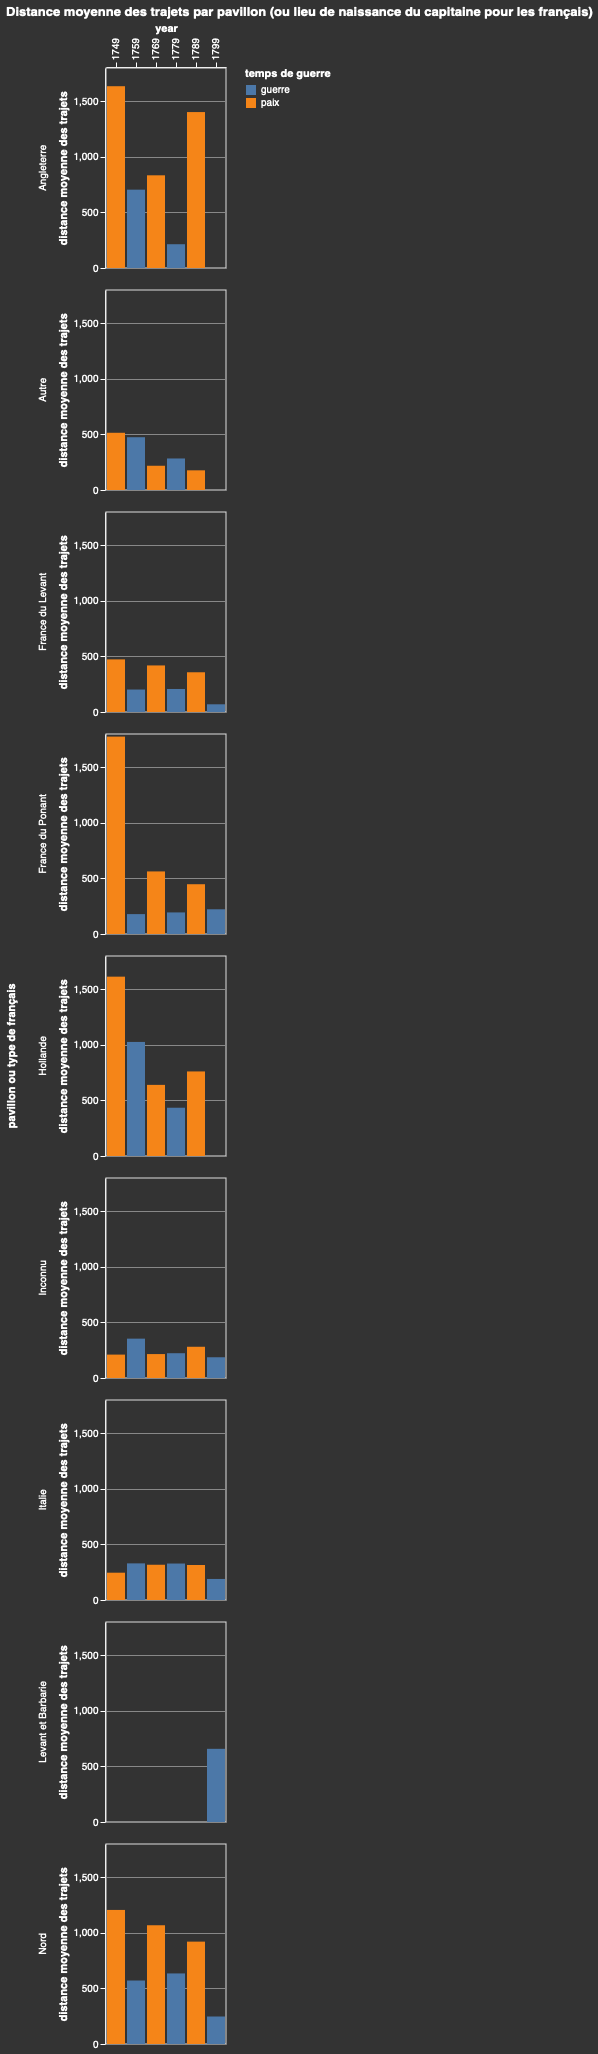

In [9]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Distance moyenne des trajets par pavillon (ou lieu de naissance du capitaine pour les français)",
    "mark": {
        "tooltip": {
         "content": "data"
        },
        "type": "bar"
    },
    "data": {
        "values": travels_list
    },
    "encoding": {
        "x": {
            "field": "year",
            "type": "nominal", 
            "title": "year",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "field": "total_miles",
            "aggregate": "mean",
            "type": "quantitative",
            "title": "distance moyenne des trajets"
        },
        "color": {
            "field": "wartimes",
            "type": "nominal",
            "title": "temps de guerre"
        },
        "row": {
            "field": "flag_class",
            "type": "nominal",
            "title": "pavillon ou type de français"
        }
    }
})

# [obsolète] Test d'une méthode alternative (abandonné)

In [10]:
"""
marseille_docs = {}
count_sante = 0

finals = set()

with open('../../data/navigo_all_flows.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row["source_suite"] == "la Santé registre de patentes de Marseille":
            if row["destination_uhgs_id"] == 'A9999997':
                counter_uhgs_99999 += 1
                continue
            count_sante += 1
            doc_id = row['source_doc_id']
            rank = row['travel_rank']
            if doc_id not in marseille_docs:
                marseille_docs[doc_id] = {}
            marseille_docs[doc_id][rank] = row
            
for doc_id, flows in marseille_docs.items():
    ordered_flows_list = [c[1] for c in sorted(flows.items(), key=lambda c: int(c[0]))]
    until_marseille = []
    for flow in ordered_flows_list:
        until_marseille.append(flow)
        if flow['destination'] == 'Marseille':
            break
        
    marseille_docs[doc_id] = until_marseille
    finals.add(marseille_docs[doc_id][-1]['destination'])
finals
"""


'\nmarseille_docs = {}\ncount_sante = 0\n\nfinals = set()\n\nwith open(\'../../data/navigo_all_flows.csv\', newline=\'\') as csvfile:\n    reader = csv.DictReader(csvfile)\n    for row in reader:\n        if row["source_suite"] == "la Santé registre de patentes de Marseille":\n            if row["destination_uhgs_id"] == \'A9999997\':\n                counter_uhgs_99999 += 1\n                continue\n            count_sante += 1\n            doc_id = row[\'source_doc_id\']\n            rank = row[\'travel_rank\']\n            if doc_id not in marseille_docs:\n                marseille_docs[doc_id] = {}\n            marseille_docs[doc_id][rank] = row\n            \nfor doc_id, flows in marseille_docs.items():\n    ordered_flows_list = [c[1] for c in sorted(flows.items(), key=lambda c: int(c[0]))]\n    until_marseille = []\n    for flow in ordered_flows_list:\n        until_marseille.append(flow)\n        if flow[\'destination\'] == \'Marseille\':\n            break\n        \n    marse